In [21]:
#Comments in this code are based on the parameters TrainingPercent = 80, ValidationPercent = 10 and TestPercent = 10

from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

In [22]:
maxAcc = 0.0
maxIter = 0
'''Regularisation factor initialised to 0.1'''
C_Lambda = 0.1 
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
'''Number of basis functions '''
M = 1
PHI = []
IsSynthetic = False

In [23]:
'''GetTargetVector takes Querylevelnorm_t.csv as an input and processes it.  This file has target data values 0,1,2 
illustrating the relevance, larger the relevance label, the better is the match between query and document. It returns a list 
t with 69623 rows and 1 column'''
def GetTargetVector(filePath):
    t = []
    '''The file Querylevelnorm_t.csv is opened in an rU modewhich an universal newline mode, 
    this mode basically supports all operating systems.'''
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    '''It returns a list t with 69623 rows and 1 column'''
    return t

'''GenerateRawData takes Querylevelnorm_X.csv as an input and processes it. The parameter IsSynthetic is redundant in this code
and can be overlooked. Querylevelnorm_X.csv has in total 69623 rows and 46 columns. Where the number 46 is the number of features.'''
def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    '''The file Querylevelnorm_X.csv is opened in an rU mode which is again an universal newline mode.'''
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    '''At this moment, dataMatrix, which is a list, has 69623 rows and 46 columns. But by looking at the dataset i.e 
    Querylevelnorm_X.csv, we can see that columns 5,6,7,8 and 9 are 0 valued. Thus, we can delete them.'''
    if IsSynthetic == False :
        '''Deleting columns 5,6,7,8 and 9, thus 46 features will now be reduced to 41'''
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)
    '''Here, we are exclusively taking the transpose of dataMatrix. i.e After deleting the mentioned columns, we had dataMatrix
    of the order (69623,41). As we now take the tranpose we will have the order of the dataMatrix as (41, 69623). This has been
    done because we want to use (41, 69623) order of 'RawData' (this function returns dataMatrix and it is stored in a 
    list called RawData) in functions such as:
    1. GenerateTrainingDataMatrix()
    2. GenerateValData()  
    3. GenerateBigSigma(): : We want to preserve the order of rawData which is (41, 69623) because we are using the same in order
    to populate 'vct', there the loop i runs from 0 to 41 and j runs from 0 to 55699, in that we are populating vct by adding
    elements from RawData[i][j]. Thus after populating 55699 values, after every iteration the variance is calculated and then
    store in varVect[], which is again a 1D list.
    4. GetPhiMatrix()'''
    dataMatrix = np.transpose(dataMatrix)     
    #print ("Data Matrix Generated..")
    '''After performing deletions, dataMatrix is returned of the order (41, 69623) '''
    return dataMatrix

'''GenerateTrainingTarget takes RawTarget and TrainingPercent as an input. Since we decided 80,10,10 as the Training, Validation
and Test split, TrainingPercent has 80 value. RawTarget is of the order (69623,). RawTarget is passed in rawTraining in this
method.'''
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    '''TrainingLen is calculated as per the 80% split of the overall dataset. len(rawTraining) has the value 69623, thus the
    calculation for TrainingLen is (69623 * 80 * 0.01) = 55698.4, which is rounded off to the nearest integer as 55699.'''
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    '''All values starting from 0 to 55699 are considered in Training Target set.'''
    return t

'''GenerateTrainingDataMatrix accepts RawData as an input and TrainingPercent as 80, which is the decided Training split.'''
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    '''The order of RawData is (41, 69623), thus len(RawData[0]) will have the value 69623. T_len is calculated as:
    69623 * 0.01 * 80 ~ 55699'''
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    '''Now, d2 will be returned of the order (41, 55699)'''
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

'''GenerateValData accepts RawData as the input, ValidationPercent/TestPercent and len(TrainingTarget). 
len(TrainingTarget) = 55699 is passed to TrainingCount. ValidationPercent/TestPercent = 10 is passed to ValPercent.'''
def GenerateValData(rawData, ValPercent, TrainingCount): 
    '''Calculation of valSize is (69623 * 10 * 0.01) ~ 6962'''
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    '''E_End = 55699 + 6962 = 62662'''
    V_End = TrainingCount + valSize
    print(V_End)
    '''dataMatrix will return values all 41 features and column values starting from 55700 up until 62662'''
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

'''GenerateValTargetVector accepts RawTarget, ValidationPercent/TestPercent and len(TrainingTarget).'''
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    '''valSize is calculated as (69623 * 10 * 0.01) ~ 6962'''
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    '''V_End is 55699 + 6962 = 62662'''
    V_End = TrainingCount + valSize
    '''t will store values from 55700 to 62662'''
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

'''GenerateBigSigma takes RawData, Mu, TrainingPercent and IsSynthetic as input. However, Mu and IsSynthetic do no play any role
in the code mentioned below.'''
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    '''Basically we are calculating Covariance Matrix and extracting Variance from the diagonal elements of that Covariance
    Matrix'''
    '''Covariance matrix is where we calculate variance of a feature with every other feature'''
    '''We are creating a numpy array called BigSigma of the order (41, 41) as len(Data) = 41 nad len(Data[0])= 69623'''
    BigSigma    = np.zeros((len(Data),len(Data)))
    '''DataT is of the order (69623, 41)'''
    DataT       = np.transpose(Data)
    '''TrainingLen = 69623 * 80 * 0.01 ~ 55699'''
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    '''For every iteration of i, which takes values from 0 to 40, varVect will store the variance of features ranging from
    0 to 41 i.e it will store the variance of all 41 features'''
    varVect     = []
    '''DataT[0] = 41'''
    for i in range(0,len(DataT[0])):
        '''For every feature, vct will store the number of training samples from RawData. It will store values ranging from
        0 to 55699 as TrainingLen is 55699'''
        '''In every iteration vct is getting initialized thus considering new feature in every iteration'''
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct)) #Variance is how far a set of numbers are spread out from their average value
    '''Up until this point, varVect will have 41 values corresponding to variances of 41 features'''
    '''The following loop will store all the variances of 41 features into the diagonal elements of the matrix BigSigma'''
    '''We are doing so because in order to calculate the gaussain radial basis function, we want to invert this matrix BigSigma'''
    '''BigSigma is of the order (41, 41)'''
    '''Since IsSynthetic is always false, Following code randomly multiplies a scalar value 200 with BigSigma '''
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

'''GetScalar accepts DataRow i.e x in terms of our gaussain radial basis function vector form, MuRow i.e Mu, and BigSigInv which
is nothing but the inverse of BigSigma'''
def GetScalar(DataRow,MuRow, BigSigInv):  
    '''R is calculating (x-Mu)'''
    R = np.subtract(DataRow,MuRow)
    '''T is calculating (BigSigmaInverse.transpose(x-Mu))'''
    T = np.dot(BigSigInv,np.transpose(R)) 
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    '''phi_x calculates the vector form of gaussian radial basis function'''
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    '''Example: DataT is of the order (69623, 10) for TrainingData'''
    DataT = np.transpose(Data)
    '''For TrainingData, TrainingLen = 55699'''
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    '''PHI is of the order (55699, 10)'''
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    #print(BigSigma)
    '''Calculating BigSigInv to compute the term Sigma Inverse from the gaussain radial basis function vector form'''
    BigSigInv = np.linalg.inv(BigSigma)
    #print(BigSigInv)
    '''len(MuMatrix) = 10 and TrainingLen = 55699'''
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            '''R takes the values from 0 to 55698 and C takes the values from 0 to 9'''
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

'''GetWeightsClosedForm gives us the values of the updated weights. It accepts PHI, T as TrainingTarget, Lambda = 0.03
PHI is of the order (55699, 10) for TrainingData. This basically calculates the Weights using Moore- Penrose 
pseudo- Inverse Matrix notation '''
def GetWeightsClosedForm(PHI, T, Lambda):
    '''Considering an identity matrix of the order (10, 10)'''
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    '''Example: Calculating PHI_T which is of the order (10, 55699) for TrainingData'''
    PHI_T       = np.transpose(PHI)
    '''Calculating PHI_SQR which is the dot product of PHI_T and PHI, order is (10, 10)'''
    PHI_SQR     = np.dot(PHI_T,PHI)
    '''Calculating PHI_SQR_LI which corresponds to the term ((lambda*I)+(transpose(PHI).PHI)). It is of the order (10, 10)'''
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    '''Calculating inverse of PHI_SQR_LI'''
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    '''Calculating INTER which is nothing but (PHI_SQR_INV.PHI_T), it is of the order (10, 55699)'''
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    '''Calculating updated weights, of the order (10, 1)'''
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

'''Returns the output'''
def GetValTest(VAL_PHI,W):
    
    Y = np.dot(W,np.transpose(VAL_PHI))
    return Y

'''Calculates the ERMS value'''
'''VAL_TEST_OUT stores Training_PHI/VAL_PHI/TEST_PHI, ValDataAct has TrainingTarget'''
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    '''Counter stores the number of times the target label was predicted was perfectly matched with the target output given '''
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [24]:
'''Fetches the input files '''
RawTarget = GetTargetVector('Querylevelnorm_t.csv')
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)

C:\Users\Sahil\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 'U' mode is deprecated
  
C:\Users\Sahil\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 'U' mode is deprecated


## Prepare Training Data

In [25]:
'''Generating the TrainingTarget and TrainingData by performing partioning of the original dataset'''
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(55699,)
(41, 55699)


## Prepare Validation Data

In [26]:
'''Partitioning for Validation set'''
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

62662
(6962,)
(41, 6962)


## Prepare Test Data

In [27]:
'''Partitioning for test set'''
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

69624
(6962,)
(41, 6962)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

In [28]:
ErmsArr = []
AccuracyArr = []
'''We are doing kmeans clustering to find suitable number of cluster centroids. The cluster centroids would help us determine
the number of gaussian basis functions and their mean'''
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
'''Why Transpose?
Because fit requires an array where the shape is (n_samples, m_features). But our initial TrainingData is of the order (41, 55699)
But here we need the order to be (55699, 41) i.e n_samples, m_features, thus we perform a transpose operation'''
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

In [29]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
#print(len(W))
#print(W)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(1, 41)
(41, 41)
(55699, 1)
(6962, 1)
(6961, 1)


## Finding Erms on training, validation and test set 

In [30]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
print("TrainingAccuracy",TrainingAccuracy)
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
print ("ValidationAccuracy",ValidationAccuracy)
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))
print ("TestAccuracy",TestAccuracy)

TrainingAccuracy 74.52198423670085,0.5651378688423746
ValidationAccuracy 75.17954610744039,0.5543829406814273
TestAccuracy 70.23416175836805,0.6402356829691717


In [31]:
print ('UBITname      = sahilsuh')
print ('Person Number = 50289739')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')
print ("M = 1 \nLambda = 0.1")
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))

UBITname      = sahilsuh
Person Number = 50289739
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 1 
Lambda = 0.1
E_rms Training   = 0.5651378688423746
E_rms Validation = 0.5543829406814273
E_rms Testing    = 0.6402356829691717


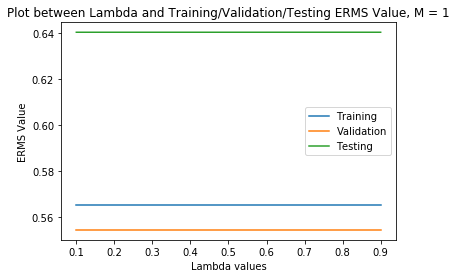

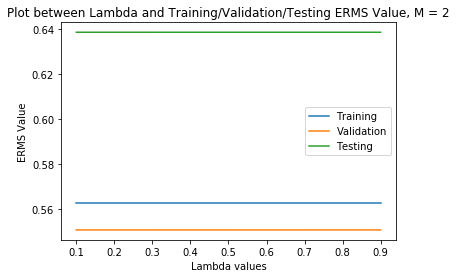

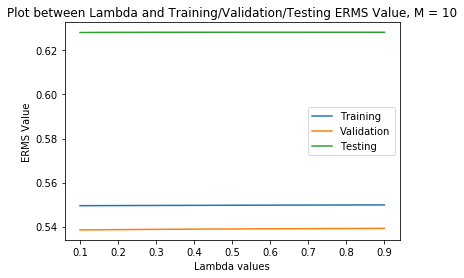

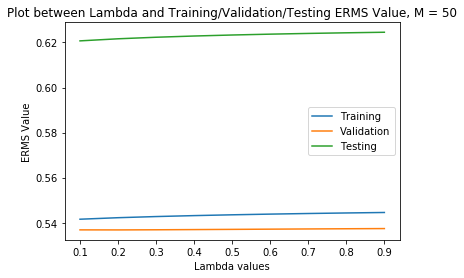

In [32]:
#Experiments

'''When M = 1, Relationship between Lambda and ERMS for Training Set, Validation Set and Testing Set'''
Lambda_1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
TR_ERMS_1 = [0.5651378688423746, 0.5651378688435513, 0.565137868845509, 0.5651378688482578, 0.5651378688517864, 0.5651378688560998,
            0.5651378688611969, 0.5651378688670756, 0.5651378688737423]
VAL_ERMS_1 = [0.5543829406814273, 0.5543829279319872, 0.5543829151834043, 0.5543829024356742, 0.5543828896888023, 0.554382876942785,
             0.5543828641976237, 0.5543828514533176, 0.5543828387098652]
T_ERMS_1 = [0.6402356829691717, 0.6402357601204745, 0.6402358372721239, 0.6402359144241183, 0.640235991576458, 0.6402360687291448, 
            0.6402361458821784, 0.6402362230355565, 0.6402363001892816]
plt.plot(Lambda_1, TR_ERMS_1, label = 'Training')
plt.plot(Lambda_1, VAL_ERMS_1, label = 'Validation')
plt.plot(Lambda_1, T_ERMS_1, label = 'Testing')
plt.xlabel('Lambda values')
plt.ylabel('ERMS Value')
plt.title('Plot between Lambda and Training/Validation/Testing ERMS Value, M = 1')
plt.legend()
plt.show()

'''When M = 2, Relationship between Lambda and ERMS for Training Set, Validation Set and Testing Set'''
Lambda_2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
TR_ERMS_2 = [0.5627948149944119, 0.5627948183333238, 0.5627948238859702, 0.5627948316424212,0.5627948415927972,0.5627948537272447,0.5627948680359659,
0.5627948845092149, 0.5627949031372693]

VAL_ERMS_2 = [0.5509387527165319, 0.5509395553129974,0.5509403588784759,0.5509411634059046,0.5509419688882601,0.5509427753185476,
0.5509435826898135,0.5509443909951363,0.5509452002276315]

T_ERMS_2 = [0.638449182307033,0.6384489991213015,0.6384488181998508,0.6384486395332776,0.6384484631122302,0.6384482889273918,
0.6384481169694886,0.6384479472292846,0.6384477796975866]

plt.plot(Lambda_2, TR_ERMS_2, label = 'Training')
plt.plot(Lambda_2, VAL_ERMS_2, label = 'Validation')
plt.plot(Lambda_2, T_ERMS_2, label = 'Testing')
plt.xlabel('Lambda values')
plt.ylabel('ERMS Value')
plt.title('Plot between Lambda and Training/Validation/Testing ERMS Value, M = 2')
plt.legend()
plt.show()


'''When M = 10, Relationship between Lambda and ERMS for Training Set, Validation Set and Testing Set'''
Lambda_10 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
TR_ERMS_10 = [0.5495138127085464,0.5495684048344792,0.5496184028685661,0.5496652683214609,0.549709369084412,0.5497509568481201,
0.5497902629351704,0.549827498063084,0.5498628487549053]


VAL_ERMS_10 = [0.5385150200433642,0.5386478517405763,0.5387635628826766,0.5388629310082516,0.5389490530962439,0.5390246156543649,
0.5390916977152266,0.5391518774092154,0.5392063570107043]


T_ERMS_10 = [0.6281151520201143,0.6281846747729138,0.6282134745004091,0.6282266300255681,0.6282321603009604,0.6282335875446705,
0.6282327270435593,0.6282306006752241,0.6282278135552045]


plt.plot(Lambda_10, TR_ERMS_10, label = 'Training')
plt.plot(Lambda_10, VAL_ERMS_10, label = 'Validation')
plt.plot(Lambda_10, T_ERMS_10, label = 'Testing')
plt.xlabel('Lambda values')
plt.ylabel('ERMS Value')
plt.title('Plot between Lambda and Training/Validation/Testing ERMS Value, M = 10')
plt.legend()
plt.show()


'''When M = 50, Relationship between Lambda and ERMS for Training Set, Validation Set and Testing Set'''
Lambda_50 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
TR_ERMS_50 = [0.5415495064646513,0.542222244387187,0.5427325742967881,0.5431523159417327,0.5435085763629482,0.5438166648151262,
0.5440866977755379,0.5443258928802301,0.5445396340935544]



VAL_ERMS_50 = [0.5368214467110219,0.5368020591528851,0.5368616443639317,0.5369482117437645,0.5370427685339039,0.5371374924689388,
0.5372290214437269,0.5373159683058648,0.5373978726541355]



T_ERMS_50 = [0.6207069259022228,0.6216302197012522,0.622316736279007,0.6228627657197855,0.6233118328573474,0.6236894427669977,
0.6240122824831443,0.6242919659854715,0.6245369147281961]


plt.plot(Lambda_50, TR_ERMS_50, label = 'Training')
plt.plot(Lambda_50, VAL_ERMS_50, label = 'Validation')
plt.plot(Lambda_50, T_ERMS_50, label = 'Testing')
plt.xlabel('Lambda values')
plt.ylabel('ERMS Value')
plt.title('Plot between Lambda and Training/Validation/Testing ERMS Value, M = 50')
plt.legend()
plt.show()

## Gradient Descent solution for Linear Regression

In [33]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [34]:
'''Here we are randomly multiplying a constant value to the weights obtained from Closed Form Solution. We are using these
random weights as the initial weights for our calculation'''
W_Now        = np.dot(200, W)
La           = 2
learningRate = 0.1
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

'''The training is done on 400 datapoints'''
for i in range(0,400):
    '''SGD defines that new weights = initial weights + updated weights i.e for eg. w2 = w1 + delta(w1) where w1 is the 
    initial weight and delta(w1) is the change in weight'''
    '''delta(w) = - (learning_rate).(delta(E))'''
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [35]:
print ('----------Gradient Descent Solution--------------------')
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
E_rms Training   = 0.56514
E_rms Validation = 0.55429
E_rms Testing    = 0.63595
